<a href="https://colab.research.google.com/github/anubhavshrestha/Machine-Learning/blob/main/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import cv2## image processing
import os## operating system
import random
import copy
from google.colab import files
import torch, torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anubhavshresthax","key":"9e69bc28da132f9241cf33f835662d15"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria --force

100% 675M/675M [00:32<00:00, 23.0MB/s]
100% 675M/675M [00:32<00:00, 21.6MB/s]


In [ ]:
!unzip /content/cell-images-for-detecting-malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
  inflating: cell_im

In [ ]:
train_paths_parasitized = []
train_paths_uninfected = []

train_paths_parasitized += os.listdir('cell_images/Parasitized')      #load the names of all files into the list
train_paths_parasitized = ['cell_images/Parasitized/' + i for i in train_paths_parasitized]     # copying absolute path of the images inside the list

train_paths_uninfected += os.listdir('cell_images/Uninfected')
train_paths_uninfected = ['cell_images/Uninfected/' + i for i in train_paths_uninfected]

paths = train_paths_parasitized + train_paths_uninfected

paths.remove("cell_images/Parasitized/Thumbs.db")
paths.remove("cell_images/Uninfected/Thumbs.db")

random.shuffle(paths)

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
train_paths = paths[0:int(train_ratio*len(paths))]
val_paths = paths[int(train_ratio*len(paths)):int((train_ratio+val_ratio)*len(paths))]
test_paths = paths[int((train_ratio+val_ratio)*len(paths)):]
print(len(test_paths), len(val_paths), len(train_paths))

2756 2756 22046


In [ ]:
class Malaria(Dataset):
  def __init__(self, image_filepaths, transform = None):
    self.image_filepaths = image_filepaths
    self.transform = transform

  def __len__(self):
    return len(self.image_filepaths)

  def __getitem__(self, index):

    image = cv2.imread(self.image_filepaths[index])

    if(self.image_filepaths[index].split('/')[1] == 'Parasitized'):
      label = 0.0
    else:
      label = 1.0


    if self.transform:
      image = self.transform(image = image)['image']

    return image, label

In [ ]:
IM_SIZE = 224
transform = A.Compose([
                        A.Resize(IM_SIZE, IM_SIZE),

                        A.OneOf([A.HorizontalFlip(),
                                 A.VerticalFlip(),], p = 0.3),

                        A.RandomRotate90(),
                        A.RandomBrightnessContrast(brightness_limit=0.2,
                                                  contrast_limit=0.2,
                                                  always_apply=False, p=0.5),
                        A.Normalize(),


])

In [ ]:
train_dataset = Malaria(train_paths, transform)
val_dataset = Malaria(val_paths, transform)
test_dataset = Malaria(test_paths, transform)

In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [ ]:
image, label = next(iter(train_loader))

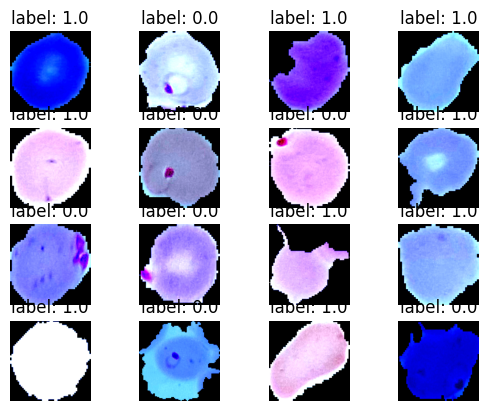

In [ ]:

for i, (image, label) in enumerate(train_loader):
    ax = plt.subplot(4, 4, i + 1)

    # Assuming the batch size is 16 (4x4 grid), access each image in the batch:
    plt.imshow(image[0])  # Assuming you want to display the first image in each batch

    plt.title('label: {}'.format(label[0]))  # Assuming you want to display the label of the first image
    plt.axis('off')

    if i == 15:  # Assuming you only want to display the first 16 images (4x4 grid)
        break

plt.show()

In [ ]:
H, W, C = image[0].shape

In [ ]:
print(H,C,W)

224 3 224


In [ ]:
device = 'cuda'

In [ ]:
#to Functional API, using functional subclassing
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        P = 1
        S = 1
        F = 5


        #initial calculation for what the H and W that go inside the first linear layer will be
        H, W, C = image[0].shape

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=C, out_channels=16, kernel_size=F, stride=S, padding=P, device = device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # after first conv:
        H = int((H + 2 * P -F) / S) + 1
        W = int((W + 2 * P- F) / S) + 1

        #after first pooling
        H = H//2
        W = W//2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1, device = device),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)

        )
         # after second conv:
        H = int((H + 2 * P - (F - 1) - 1) / S) + 1
        W = int((W + 2 * P- (F - 1) - 1) / S) + 1

        #after second pooling
        H = H//2
        W = W//2

        # Define fully connected layers
        self.fc1 = nn.Linear(32 * H * W, 1000, device = device)  # Assuming H and W are 56 after two max-pooling layers
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1000, 100, device = device)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(100, 1, device = device)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # First Convolutional Block
        x = self.conv_block1(x)

        # Second Convolutional Block
        x = self.conv_block2(x)

        # Flatten
        x = x.reshape((x.shape[0], -1))  # Reshape to (batch_size, 32 * H * W) #flattening


        # Fully Connected Layers
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)

        return x

# Create an instance of your model
model = CNN_model()
print(model)

CNN_model(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=93312, out_features=1000, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)

In [ ]:
if torch.cuda.is_available:
    print("CUDA is available!")
    device = torch.device('cuda')

else:
    print("No GPU found. Training will be done on CPU.")
    device = torch.device("cpu")
print(device)

CUDA is available!
cuda


In [ ]:
def round(x):
  if(x>=0.5):
    return 1
  return 0

In [ ]:
def get_accuracy(epoch):
  model.eval()
  with torch.no_grad():
    epoch_accuracy = 0
    for i, (image, label) in enumerate(val_loader):
      image = torch.permute(image, (0,3,1,2))
      image = image.to(device)
      output = model(image)

      for i in range(len(output)):
        if(round(output[i].item()) == label[i].item()):
          epoch_accuracy += 1

  print("The Validation Accuracy for this epoch:{} is:{} ".format(epoch+1, 100*epoch_accuracy/len(val_dataset)))

In [ ]:
model.to(device)
num_epochs = 5
losses = []
val_losses = []

patience = 2  # Number of epochs without improvement to tolerate
min_delta = 0.001  # Minimum change in validation loss to be considered an improvement
best_val_loss = float('inf')
current_patience = 0


for i in range(num_epochs):
  loss_sum = 0.0
  v_loss_sum = 0.0

  for j, k in zip(train_loader, val_loader):
    data_x =j[0].to(device)
    data_y = j[1].to(device)
    data_y = data_y.reshape((data_y.shape[0], -1))


    #because in pytorch the data is expected in the form of N x C X H X W, but currently it's in the form N X H X W X C
    data_x = data_x.permute(0,3,1,2)
    prediction = model(data_x)

    prediction = prediction.float()
    data_y = data_y.float()
    loss = criterion(prediction, data_y)

    loss_sum += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    model.eval()
    with torch.no_grad():
      val_x = k[0].to(device)
      val_y = k[1].to(device)
      val_y = val_y.reshape((val_y.shape[0], -1))
      val_x = val_x.permute(0,3,1,2)



      val_pred = model(val_x)

      val_pred = val_pred.float()
      val_y = val_y.float()
      v_loss = criterion(val_pred, val_y)

      v_loss_sum += v_loss

  avg_loss = loss_sum/len(train_loader)
  losses.append(avg_loss)
  avg_v_loss =  v_loss_sum/len(val_loader)
  val_losses.append(avg_v_loss)
  print(f"Epoch [{i + 1}/{num_epochs}], Train Loss: {avg_loss.item():.4f}, Val Loss: {avg_v_loss.item():.4f}")
  get_accuracy(i)

  if avg_v_loss + min_delta < best_val_loss:
        best_val_loss = avg_v_loss
        current_patience = 0
  else:
      current_patience += 1
      if current_patience >= patience:
          print("Early stopping! No improvement in validation loss for {} epochs.".format(patience))
          break



Epoch [1/5], Train Loss: 0.0369, Val Loss: 0.2630
The Validation Accuracy for this epoch:1 is:91.43686502177069 
Epoch [2/5], Train Loss: 0.0343, Val Loss: 0.2545
The Validation Accuracy for this epoch:2 is:91.14658925979681 
Epoch [3/5], Train Loss: 0.0303, Val Loss: 0.2358
The Validation Accuracy for this epoch:3 is:93.21480406386067 
Epoch [4/5], Train Loss: 0.0335, Val Loss: 0.2377
The Validation Accuracy for this epoch:4 is:93.39622641509433 
Epoch [5/5], Train Loss: 0.0314, Val Loss: 0.2276
The Validation Accuracy for this epoch:5 is:92.59796806966618 


In [ ]:
test_loss_sum = 0.0

t = 0
test_loss_sum = 0
epoch_accuracy = 0
for m in test_loader:
  model.eval()
  with torch.no_grad():
      test_x = m[0].to(device)
      test_y = m[1].to(device)
      test_y = test_y.reshape((test_y.shape[0], -1))
      test_x = test_x.permute(0,3,1,2)

      test_pred = model(test_x)


      for i in range(len(test_pred)):
        if(round(test_pred[i].item()) == test_y[i].item()):

          epoch_accuracy += 1


      test_pred = test_pred.float()
      test_y = test_y.float()
      test_loss = criterion(test_pred, test_y)
      test_loss_sum += test_loss
print("Test Accuracy for Model = ", (epoch_accuracy/len(test_paths)) * 100 )
print("Loss for Model = ",test_loss_sum.item()/ len(test_paths))

Accuracy for Model =  91.21915820029028
Loss for Model =  0.007921461097041824


In [ ]:
#predicting output of one data:
def predict(x):
  model.eval()

  x = x.permute(2, 0, 1)
  x = x.unsqueeze(0).to(device)
  pred = model(x)

  if pred>= 0.5:
    return "U" #return 1
  else:
    return "P"

In [ ]:
image, label =next(iter(test_loader)) #image contains a batch of data, i.e. 32 data here

predict(image[0]) #first image of the batch we are taking

'P'

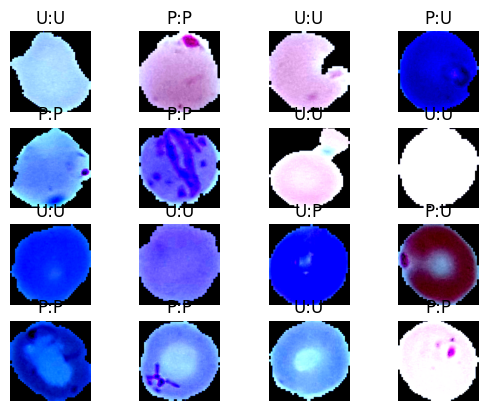

In [ ]:
#visualizing the results
count = 0
for i, (image, label) in enumerate(test_loader):
  if count == 16:
    break
  count+= 1
  random_int = random.randint(0, BATCH_SIZE-1)
  random_image_from_batch = image[random_int]
  label = label[random_int]
  if label ==1:
    correct_answer = "U"
  else:
    correct_answer = "P"
  model.eval()

  model_answer = predict(random_image_from_batch)
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(random_image_from_batch)
  plt.title(str(correct_answer) + ":" + str(model_answer))
  plt.axis("off")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Saving trained Model in the google drive
save_path = "/content/drive/My Drive/Colab Notebooks/malaria_trained.pt"
# Save the model checkpoint
torch.save(model.state_dict(), save_path)

In [ ]:
save_path = "/content/drive/My Drive/Colab Notebooks/malaria_trained.pt"
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
test_loss_sum = 0.0

t = 0
test_loss_sum = 0
epoch_accuracy = 0
for m in test_loader:
  model.eval()
  with torch.no_grad():
      test_x = m[0].to(device)
      test_y = m[1].to(device)
      test_y = test_y.reshape((test_y.shape[0], -1))
      test_x = test_x.permute(0,3,1,2)

      test_pred = model(test_x)


      for i in range(len(test_pred)):
        if(round(test_pred[i].item()) == test_y[i].item()):

          epoch_accuracy += 1


      test_pred = test_pred.float()
      test_y = test_y.float()
      test_loss = criterion(test_pred, test_y)
      test_loss_sum += test_loss
print("Accuracy for Model = ", (epoch_accuracy/len(test_paths)) * 100 )
print("Loss for Model = ",test_loss_sum.item()/ len(test_paths))

Accuracy for Model =  91.83599419448475
Loss for Model =  0.007927279340857518


In [ ]:
#predicting output of one data:
def predict(x):
  model.eval()

  x = x.permute(2, 0, 1)
  x = x.unsqueeze(0).to(device)
  pred = model(x)

  if pred>= 0.5:
    return "U" #return 1
  else:
    return "P"

In [ ]:
image, label =next(iter(test_loader)) #image contains a batch of data, i.e. 32 data here

predict(image[0]) #first image of the batch we are taking


'P'

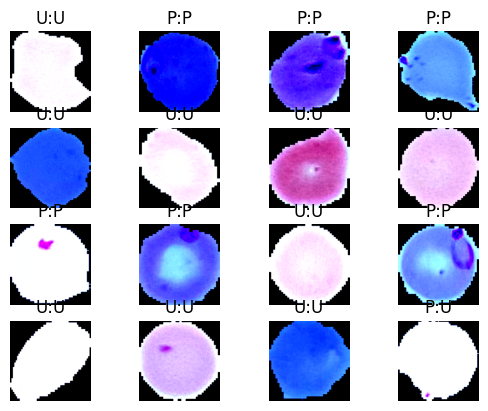

In [ ]:
#visualizing the results
count = 0
for i, (image, label) in enumerate(test_loader):
  if count == 16:
    break
  count+= 1
  random_int = random.randint(0, BATCH_SIZE-1)
  random_image_from_batch = image[random_int]
  label = label[random_int]
  if label ==1:
    correct_answer = "U"
  else:
    correct_answer = "P"
  model.eval()

  model_answer = predict(random_image_from_batch)
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(random_image_from_batch)
  plt.title(str(correct_answer) + ":" + str(model_answer))
  plt.axis("off")

In [ ]:
#more evaluation on the test set

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve



t = 0

target_np = []
predicted_probab = []
for m in test_loader:
  model.eval()
  with torch.no_grad():
      test_x = m[0].to(device)
      test_y = m[1].to(device)
      test_y = test_y.reshape((test_y.shape[0], -1))
      test_x = test_x.permute(0,3,1,2)

      test_pred = model(test_x)

      for i in range(len(test_pred)):
        predicted_probab.append(test_pred[i].item())
        target_np.append(test_y[i].item())


In [ ]:
threshold = 0.58
target_np = torch.tensor(target_np)
predicted_probab_tensor = torch.tensor(predicted_probab)
predicted_probab_np= (predicted_probab_tensor> threshold).numpy() #just like applying round fn

# Convert tensors to NumPy arrays
predicted_np = predicted_probab_np
target_np = target_np.numpy()

# Compute confusion matrix
conf_matrix = confusion_matrix(target_np, predicted_np)

# Extract individual metrics
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate other metrics
accuracy = accuracy_score(target_np, predicted_np)
precision = precision_score(target_np, predicted_np)
recall = recall_score(target_np, predicted_np)
f1 = f1_score(target_np, predicted_np)

print("Confusion Matrix:")
print(conf_matrix)
print("True Positives:", tp)
print("False Positives:", fp)
print("True Negatives:", tn)
print("False Negatives:", fn)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)



Confusion Matrix:
[[1225  107]
 [ 153 1271]]
True Positives: 1271
False Positives: 107
True Negatives: 1225
False Negatives: 153
Accuracy: 0.9056603773584906
Precision: 0.9223512336719883
Recall: 0.8925561797752809


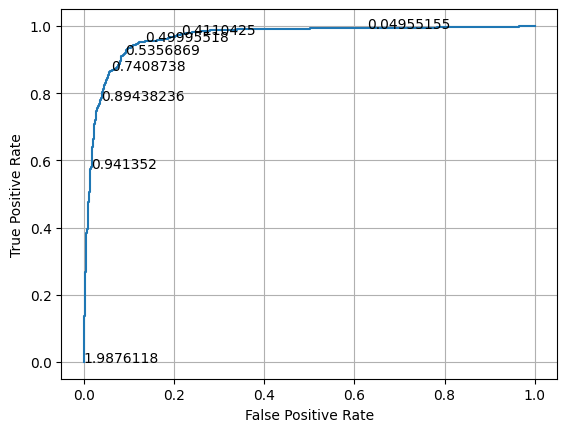

In [ ]:
#making ROC curve

predicted_probab_np = torch.tensor(predicted_probab).numpy()
fp, tp, thresholds = roc_curve(target_np, predicted_probab_np)
plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
skip = 50
for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])
plt.show()